In [1]:
%load_ext autoreload 
%autoreload 2 

In [8]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf
import json

from src.data_processing.processors.TrainingProcessor import TrainingProcessor

In [4]:
# DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip'
# MODEL_PATH = "/projects/p31961/ENIGMA/results/experiments/dopamine_full_sequence_stacked_lstm_01/models/dopamine_full_sequence_stacked_lstm_01"

# local
DATA_PATH = '/Users/mds8301/iterm_data_storage/full_dataset.parquet.gzip'
MODEL_PATH = '/Users/mds8301/Devlopment/enigma/results/experiments/dopamine_full_sequence_stacked_lstm_01/models/dopamine_full_sequence_stacked_lstm_01'

In [5]:
data = pd.read_parquet(DATA_PATH)
data

,time,sex_M,day,trial,trial_count,learning_phase,event_cue,event_escape,event_avoid,action_escape,...,mouse_id_4,mouse_id_5,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13
0,-25.000000,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,-24.901531,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,-24.803064,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,-24.704596,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,-24.606127,0,5,0,115,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5858795,19.606127,0,4,1,87,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5858796,19.704596,0,4,1,87,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5858797,19.803064,0,4,1,87,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5858798,19.901531,0,4,1,87,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
data.columns

Index(['time', 'sex_M', 'day', 'trial', 'trial_count', 'learning_phase',
       'event_cue', 'event_escape', 'event_avoid', 'action_escape',
       'action_avoid', 'latency', 'event_shock', 'sensor_D1', 'sensor_D2',
       'sensor_DA', 'signal', 'mouse_id_0', 'mouse_id_1', 'mouse_id_2',
       'mouse_id_3', 'mouse_id_4', 'mouse_id_5', 'mouse_id_6', 'mouse_id_7',
       'mouse_id_8', 'mouse_id_9', 'mouse_id_10', 'mouse_id_11', 'mouse_id_12',
       'mouse_id_13'],
      dtype='object')

In [6]:
train_processor = (TrainingProcessor(data)
                .query_sensor_and_sort_trials_by_subject(sensor='DA')
                )

In [11]:
with open('/Users/mds8301/Devlopment/enigma/results/experiments/dopamine_full_sequence_stacked_lstm_01/subjects_by_category.json', 'r') as f:
    subjects_by_category = json.load(f)
subjects_by_category

{'training': ['mouse_id_11',
  'mouse_id_10',
  'mouse_id_7',
  'mouse_id_5',
  'mouse_id_12',
  'mouse_id_2',
  'mouse_id_9',
  'mouse_id_8',
  'mouse_id_0'],
 'validation': ['mouse_id_1', 'mouse_id_13'],
 'testing': ['mouse_id_3', 'mouse_id_6', 'mouse_id_4']}

In [25]:
def query_testing_subjects(subjects, df):
    
    full_query = ''
    for mouse in subjects:
        query =f"{mouse} == 1"
        if full_query == '':
            full_query = query
        else:
            full_query += f" or {query}" 
        
    return df.query(full_query)

test_set = query_testing_subjects(subjects_by_category['testing'], train_processor.data)
X_test, y_test = test_set.drop(columns = 'signal'), test_set['signal']

In [29]:
model = tf.keras.models.load_model(MODEL_PATH)

model.compile(optimizer='adam', loss='mse', metrics=[
        'mae', 'mse', 'mape', 'cosine_similarity'])

/Users/mds8301/anaconda3/envs/enigma/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: src.models.StackedLSTM is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [30]:
model.summary()

Model: "stacked_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Lambda_1 (Lambda)           multiple                  0         
                                                                 
 LSTM_1 (LSTM)               multiple                  12096     
                                                                 
 LSTM_2 (LSTM)               multiple                  23544     
                                                                 
 Dense_output (Dense)        multiple                  55        
                                                                 
Total params: 35695 (139.43 KB)
Trainable params: 35695 (139.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
predicted_signal = model.predict(X_test)

18435/18435 [==============================] - 65s 4ms/step


In [46]:
full_test_set = (X_test
                 .assign(
                     true_signal=y_test,
                     predicted_signal = predicted_signal
                     )
                 )

In [47]:
full_test_set  = avoid.melt(id_vars = full_test_set.drop(columns = ['predicted_signal', 'true_signal']).columns, value_vars= ['predicted_signal', 'true_signal'], value_name = "signal", var_name = 'signal_type')
full_test_set

,time,sex_M,day,trial,trial_count,learning_phase,event_cue,event_escape,event_avoid,action_escape,...,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13,signal_type,signal
0,-25.000000,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.116680
1,-24.901531,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.115877
2,-24.803064,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.115060
3,-24.704596,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.114226
4,-24.606127,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.113370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382883,19.606127,1,7,25,192,2,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.317860
382884,19.704596,1,7,25,192,2,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.614339
382885,19.803064,1,7,25,192,2,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.321526
382886,19.901531,1,7,25,192,2,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,0.048894


In [48]:
avoid = full_test_set.query("action_avoid==1 & event_cue==1")
avoid

,time,sex_M,day,trial,trial_count,learning_phase,event_cue,event_escape,event_avoid,action_escape,...,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13,signal_type,signal
0,-25.000000,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.116680
1,-24.901531,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.115877
2,-24.803064,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.115060
3,-24.704596,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.114226
4,-24.606127,0,1,1,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,predicted_signal,0.113370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382883,19.606127,1,7,25,192,2,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.317860
382884,19.704596,1,7,25,192,2,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.614339
382885,19.803064,1,7,25,192,2,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.321526
382886,19.901531,1,7,25,192,2,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,0.048894


<Axes: xlabel='time', ylabel='signal'>

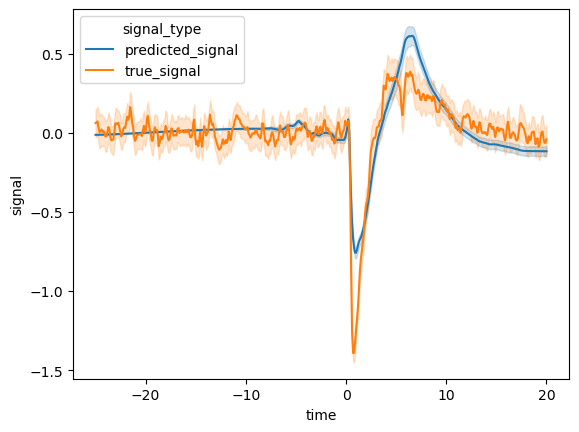

In [49]:
sns.lineplot(data = avoid, x = 'time', y = 'signal', hue = 'signal_type')
# sns.lineplot(data = query, x = 'time', y = 'predicted_signal')

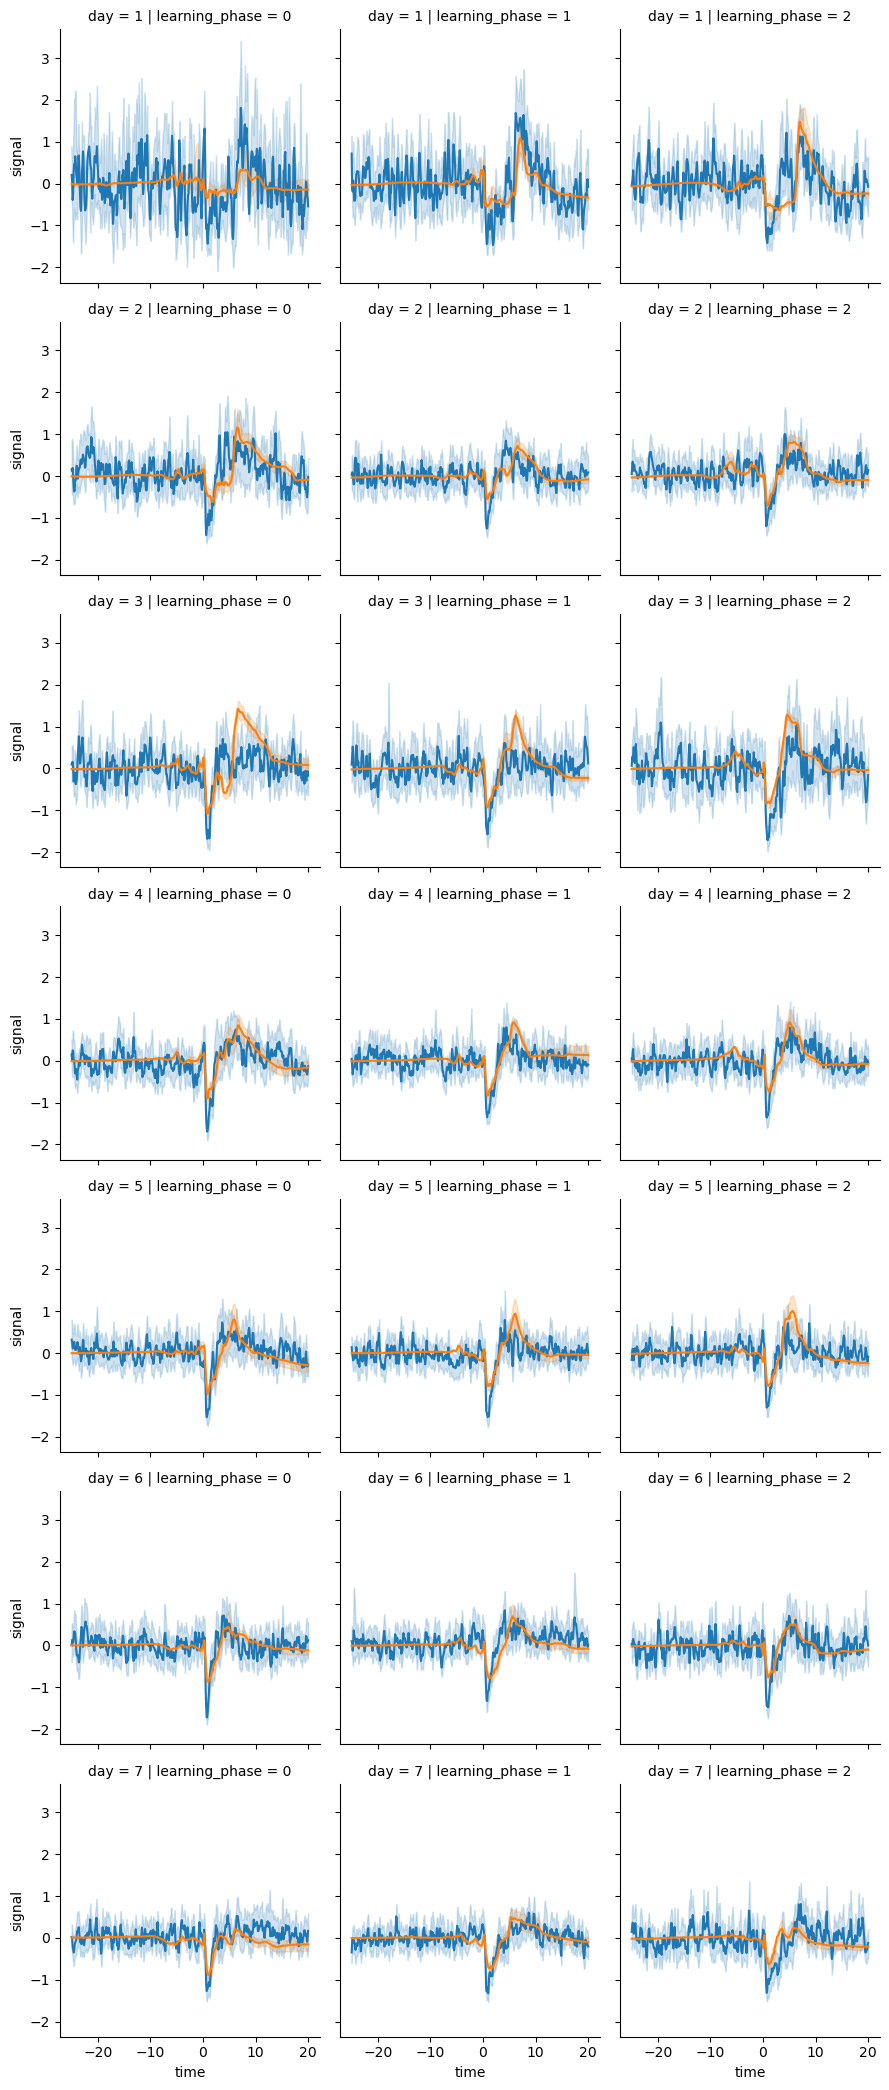

In [50]:
facet = sns.FacetGrid(avoid, row = 'day', col = "learning_phase")
facet.map_dataframe(sns.lineplot, x = 'time', y = 'signal', hue = 'signal_type', hue_order = ["true_signal", "predicted_signal"])

In [56]:
mouse_3 = avoid.query("mouse_id_3==1 & trial_count < 10")
mouse_3

,time,sex_M,day,trial,trial_count,learning_phase,event_cue,event_escape,event_avoid,action_escape,...,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13,signal_type,signal
131446,-25.000000,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,predicted_signal,-0.030396
131447,-24.901531,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,predicted_signal,-0.030724
131448,-24.803064,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,predicted_signal,-0.030899
131449,-24.704596,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,predicted_signal,-0.030936
131450,-24.606127,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,predicted_signal,-0.030853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323343,19.606127,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,0.664135
323344,19.704596,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.296202
323345,19.803064,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.674320
323346,19.901531,1,1,9,9,0,1,0,0,0,...,0,0,0,0,0,0,0,0,true_signal,-0.279552


<Axes: xlabel='time', ylabel='signal'>

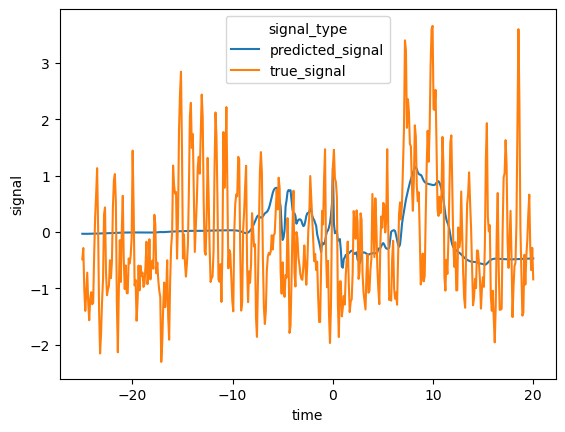

In [61]:
sns.lineplot(data = mouse_3.query("trial_count==9"), x = 'time', y = 'signal', hue = 'signal_type')

In [64]:
evalulation = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, evalulation):
    print(f'{name}: {value}')

18435/18435 [==============================] - 133s 7ms/step - loss: 1.0743 - mae: 0.8090 - mse: 1.0743 - mape: 315.9180 - cosine_similarity: 0.0587
loss: 1.0742732286453247
mae: 0.80901700258255
mse: 1.0742732286453247
mape: 315.9179992675781
cosine_similarity: 0.05868713930249214


# Summary
given the training performance data, I think this model is overfitting. I am going to experiment again with dropout layers to see how it performs